# Population-Level Growth Analysis Using DeLTA 2.0 for Microfluidic pDST

This notebook contains the analysis pipeline used to evaluate the DeLTA 2.0 framework on microfluidic time-lapse microscopy data for phenotypic drug susceptibility testing (pDST). Starting from DeLTA 2.0 segmentation and tracking outputs, growth-rate features based on cell area and length are extracted and aggregated at the population level using temporal binning and median statistics. The resulting growth trajectories are used to compare drug-treated and control conditions and to quantify drug response via the area under the growth-rate curve (AUC).

The notebook is initialized by loading outputs from the DeLTA 2.0 pipeline generated using the retrained segmentation model.

The primary purpose of this notebook is to demonstrate the analysis workflow and to reproduce the figures presented in the associated report.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install delta-microscopy[jax-gpu]

In [1]:
!ls /content/drive/MyDrive/forskningsmetodik/

 cleaned2.zip  'data_12_04 (1).zip'   final_delta_model.keras
 cleaned.zip    data_12_04.zip	     'my_model (1).keras'
 data	        data_december2.zip    results_11-17.zip


In [2]:
import delta
from delta.config import Config
import logging
from IPython.display import HTML
from base64 import b64encode
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from PIL import Image
import shutil
import os
import re
import glob
import pandas as pd
import random
from pathlib import Path

In [ ]:
!unzip /content/drive/MyDrive/forskningsmetodik/results_11-17.zip -d /content

In [58]:
# Helper Functions
def add_frame_bins(df, step=10):
    df = df.copy()
    df["frame_bin"] = (df["frame"] // step) * step
    return df


def aggregate_gr(df, step=10):
    df = add_frame_bins(df, step)

    # Growth rate (area) bin (steps)
    agg_area = df.groupby("frame_bin")["growthrate_area"].agg(
        mean="mean",
        median="median",
        std="std",
        count="count"
    )
    agg_area["sem"] = agg_area["std"] / agg_area["count"].pow(0.5)
    agg_area["smooth"] = agg_area["mean"].rolling(
        window=3, center=True, min_periods=1
    ).mean()

    # Growth rate (length) bin (steps)
    agg_length = df.groupby("frame_bin")["growthrate_length"].agg(
        mean="mean",
        median="median",
        std="std",
        count="count"
    )
    agg_length["sem"] = agg_length["std"] / agg_length["count"].pow(0.5)
    agg_length["smooth"] = agg_length["mean"].rolling(
        window=3, center=True, min_periods=1
    ).mean()

    return agg_area, agg_length


def average_area(df):
    # No binning here
    agg_area = df.groupby("frame")["area"].agg(
        mean="mean",
        median="median",
        std="std",
        count="count"
    )
    agg_area["sem"] = agg_area["std"] / agg_area["count"].pow(0.5)
    agg_area["smooth"] = agg_area["mean"].rolling(
        window=3, center=True, min_periods=1
    ).mean()

    return agg_area


def visualize_aggregated_features(df, x_label, y_label, title=""):
    plt.figure(figsize=(10,4))
    plt.plot(df.index, df["mean"], alpha=0.5, label="mean (raw)")
    plt.plot(df.index, df["smooth"], linewidth=2, label="smoothed")
    plt.fill_between(
        df.index,
        df["mean"] - df["sem"],
        df["mean"] + df["sem"],
        alpha=0.2,
        label="SEM"
    )
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


def create_df(nc_file: Path, step=10):
    pos = delta.pipeline.Position.load_netcdf(nc_file)
    roi = pos.rois[0]
    lin = roi.lineage

    rows = []
    for cell_id, cell in lin.cells.items():
        for frame in cell.frames:
            f = cell.features(frame)
            rows.append({
                "cell_id": cell_id,
                "frame": frame,
                "length": f.length,
                "area": f.area,
                "growthrate_length": f.growthrate_length,
                "growthrate_area": f.growthrate_area,
                "motherid": cell.motherid,
            })

    df_raw = pd.DataFrame(rows)

    # Binned growth rates
    agg_area, agg_length = aggregate_gr(df_raw, step)

    # Unbinned area
    avr_area = average_area(df_raw)

    return df_raw, agg_area, agg_length, avr_area


def visualize_comparison(agg1, agg2, label1, label2, y_label, title=""):
    plt.figure(figsize=(10,4))

    agg1["median_smooth"] = agg1["median"].rolling(window=3, center=True, min_periods=1).mean()
    plt.plot(agg1.index, agg1["median"], alpha=0.3, label=f"{label1} median")
    plt.plot(agg1.index, agg1["median_smooth"], linewidth=2, label=f"{label1} smoothed median")
    plt.fill_between(
        agg1.index,
        agg1["median"] - agg1["sem"],
        agg1["median"] + agg1["sem"],
        alpha=0.2
    )

    agg2["median_smooth"] = agg2["median"].rolling(window=3, center=True, min_periods=1).mean()
    plt.plot(agg2.index, agg2["median"], alpha=0.3, label=f"{label2} median")
    plt.plot(agg2.index, agg2["median_smooth"], linewidth=2, label=f"{label2} smoothed median")
    plt.fill_between(
        agg2.index,
        agg2["median"] - agg2["sem"],
        agg2["median"] + agg2["sem"],
        alpha=0.2
    )

    plt.xlabel("Frame bin")
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


def auc_growth(agg):
    x = agg.index.values
    y = agg["smooth"].values
    return np.trapz(y, x)


In [7]:
nc_files = sorted(Path("/content").glob("Position*.nc"))

results = {}
for nc in nc_files:
    df_raw, agg_area, agg_length, avr_area = create_df(nc, step=10)
    results[nc.stem] = {
        "raw": df_raw,
        "agg_area": agg_area,
        "agg_length": agg_length,
        "avr_area": avr_area,
    }


In [17]:
pairs = []
for i in range(111, 118):
    pairs.append(
        (f"Position000{i}", f"Position000{i+100}")
    )

For each matched control–drug position pair, the area under the curve (AUC) of the smoothed growth-rate trajectory was computed. Drug response was quantified as the percent change in AUC relative to the paired control:
$$100\cdot \frac{(AUC_{drug} - AUC_{ctrl})}{AUC_{ctrl}} $$
Greater negative values correspond to stronger growth inhibition and therefore higher drug susceptibility, whereas values near zero indicate resistance.

In [54]:
rows = []

for ctrl, drug in pairs:
    agg_ctrl = results[ctrl]["agg_area"]
    agg_drug = results[drug]["agg_area"]

    auc_ctrl = auc_growth(agg_ctrl)
    auc_drug = auc_growth(agg_drug)

    rows.append({
        "strain": ctrl[-3:],
        "auc_control": auc_ctrl,
        "auc_drug": auc_drug,
        "delta_auc": auc_drug - auc_ctrl,
        "percent_change": 100 * (auc_drug - auc_ctrl) / auc_ctrl
    })

sus_df = pd.DataFrame(rows).sort_values("percent_change")
sus_df

/tmp/ipython-input-341883581.py:135: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(y, x)


,strain,auc_control,auc_drug,delta_auc,percent_change
4,115,4.451433,0.809448,-3.641986,-81.816024
6,117,4.301386,1.885018,-2.416368,-56.176502
3,114,4.123103,1.974695,-2.148408,-52.106587
1,112,4.343609,2.654542,-1.689067,-38.886250
0,111,3.776717,2.789170,-0.987547,-26.148296
2,113,4.098492,3.582340,-0.516152,-12.593711
5,116,3.453173,3.181973,-0.271200,-7.853651


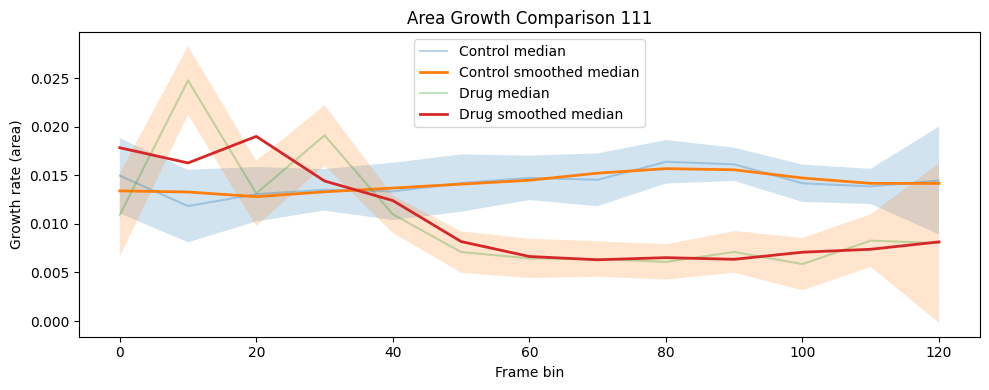

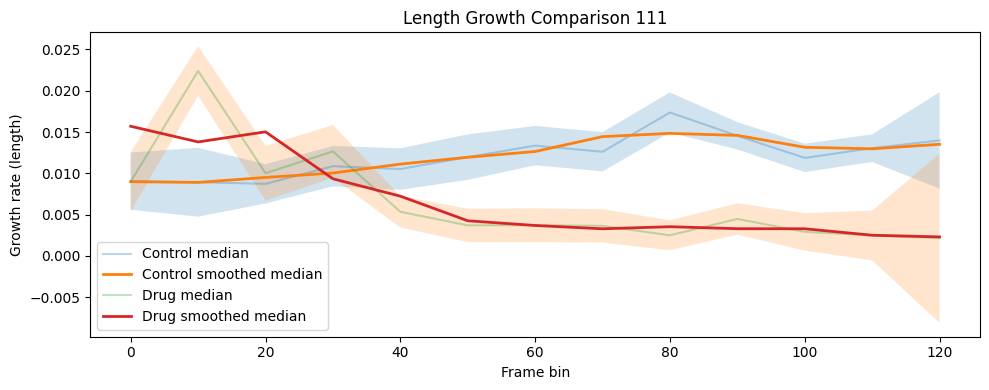

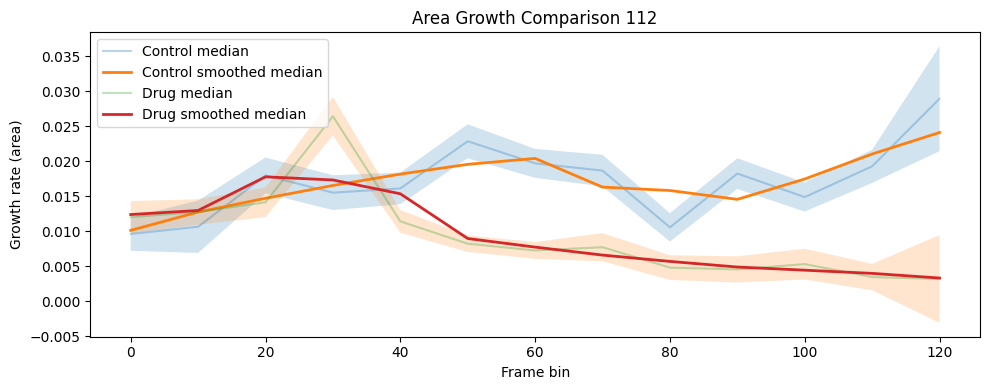

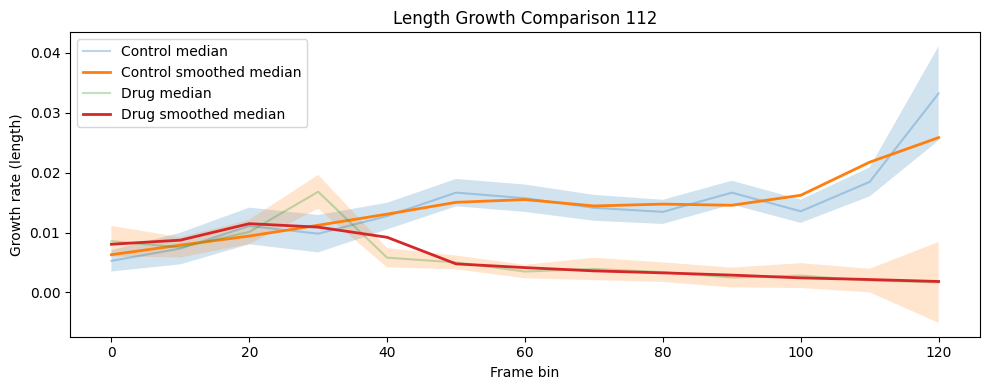

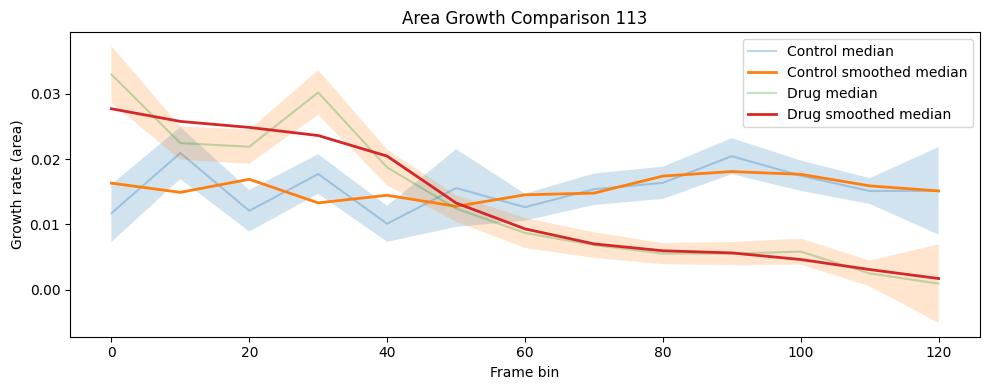

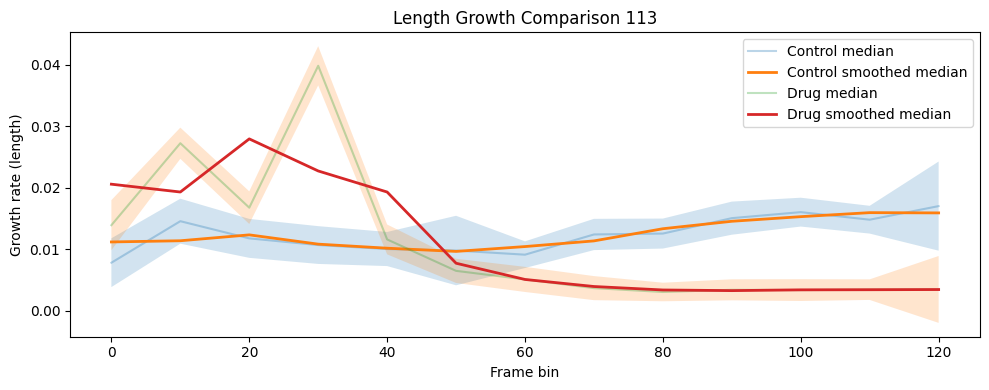

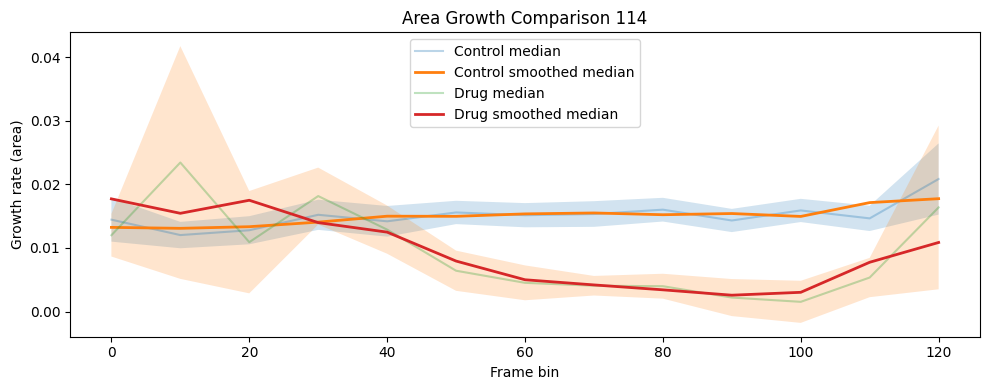

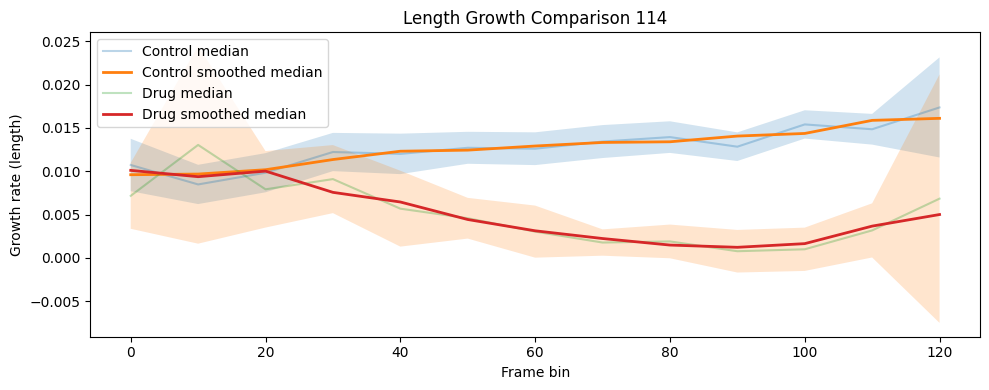

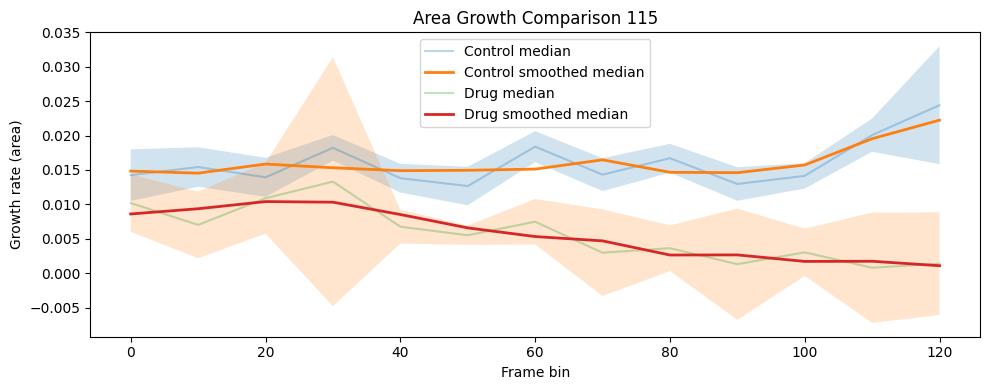

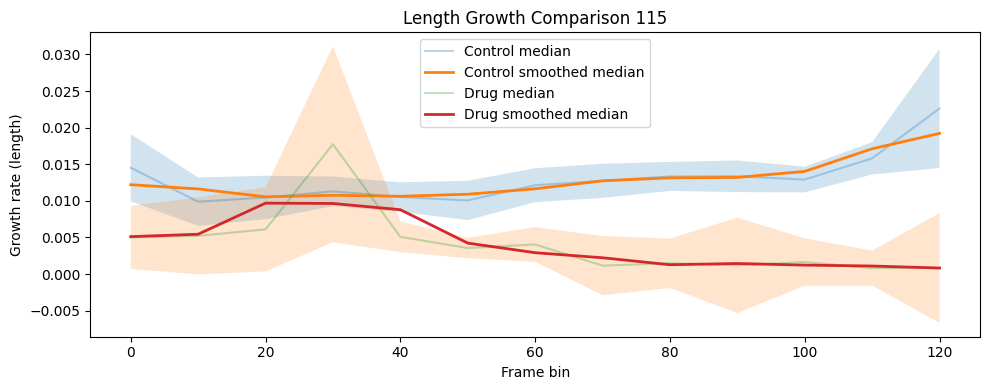

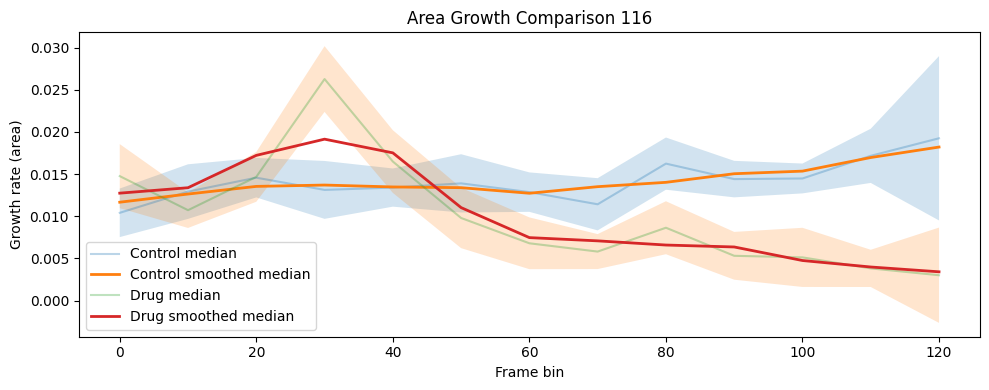

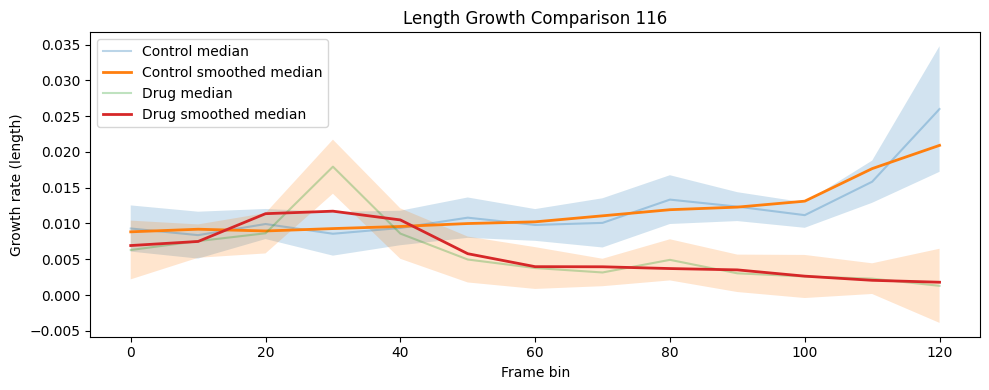

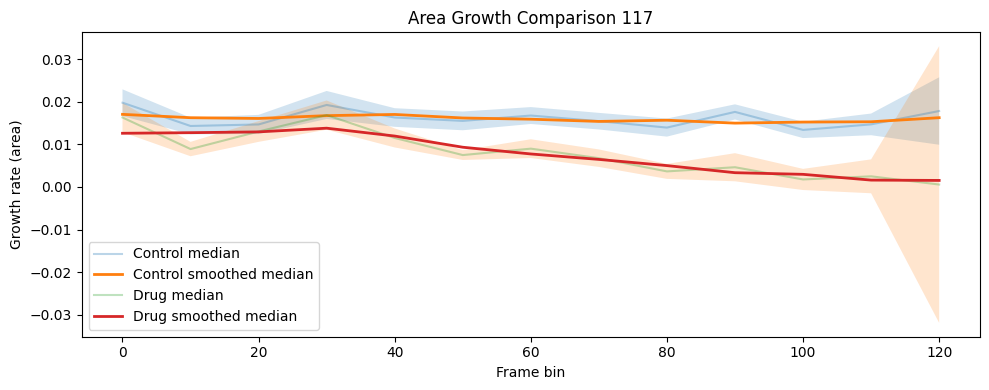

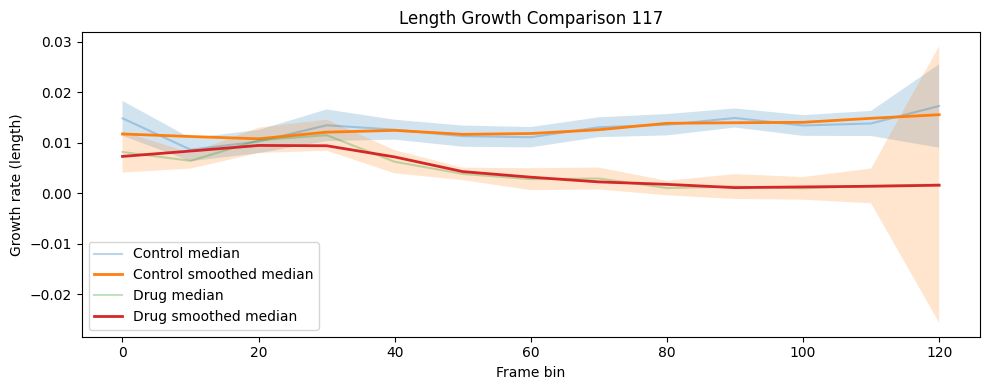

In [60]:
for ctrl, drug in pairs:
    # Area growth rate (10frame bins)
    visualize_comparison(
        results[ctrl]["agg_area"],
        results[drug]["agg_area"],
        label1="Control",
        label2="Drug",
        y_label="Growth rate (area)",
        title=f"Area Growth Comparison {ctrl[-3:]}"
    )

    # Length growth rate (10frame bins)
    visualize_comparison(
        results[ctrl]["agg_length"],
        results[drug]["agg_length"],
        label1="Control",
        label2="Drug",
        y_label="Growth rate (length)",
        title=f"Length Growth Comparison {ctrl[-3:]}"
    )

Show trends in one plot

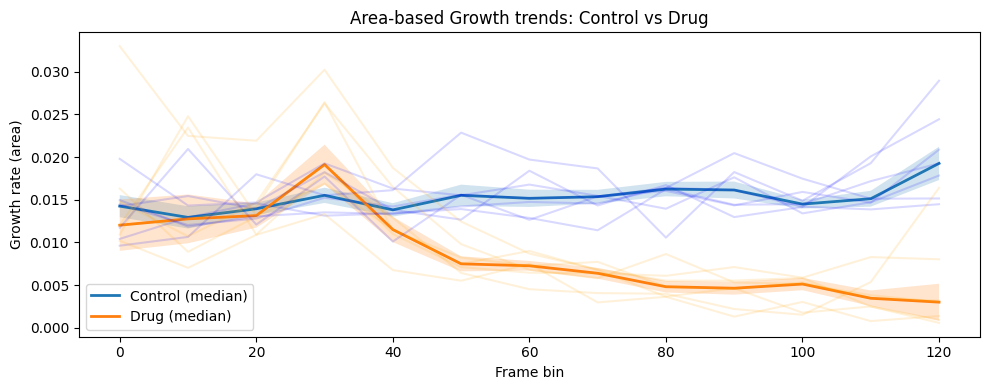

In [56]:
import pandas as pd

control_curves = []
drug_curves = []

for ctrl, drug in pairs:
    a_ctrl = results[ctrl]["agg_area"][["median"]].rename(columns={"median": ctrl})
    a_drug = results[drug]["agg_area"][["median"]].rename(columns={"median": drug})

    control_curves.append(a_ctrl)
    drug_curves.append(a_drug)

ctrl_df = pd.concat(control_curves, axis=1)
drug_df = pd.concat(drug_curves, axis=1)

ctrl_median = ctrl_df.median(axis=1)
drug_median = drug_df.median(axis=1)

ctrl_sem = ctrl_df.std(axis=1) / np.sqrt(ctrl_df.count(axis=1))
drug_sem = drug_df.std(axis=1) / np.sqrt(drug_df.count(axis=1))

plt.figure(figsize=(10,4))

plt.plot(ctrl_median.index, ctrl_median, linewidth=2, label="Control (median)")
plt.fill_between(
    ctrl_median.index,
    ctrl_median - ctrl_sem,
    ctrl_median + ctrl_sem,
    alpha=0.2
)

plt.plot(drug_median.index, drug_median, linewidth=2, label="Drug (median)")
plt.fill_between(
    drug_median.index,
    drug_median - drug_sem,
    drug_median + drug_sem,
    alpha=0.2
)

for col in ctrl_df:
    plt.plot(ctrl_df.index, ctrl_df[col], alpha=0.15, color="blue")

for col in drug_df:
    plt.plot(drug_df.index, drug_df[col], alpha=0.15, color="orange")


plt.xlabel("Frame bin")
plt.ylabel("Growth rate (area)")
plt.title("Area-based Growth trends: Control vs Drug")
plt.legend()
plt.tight_layout()
plt.show()


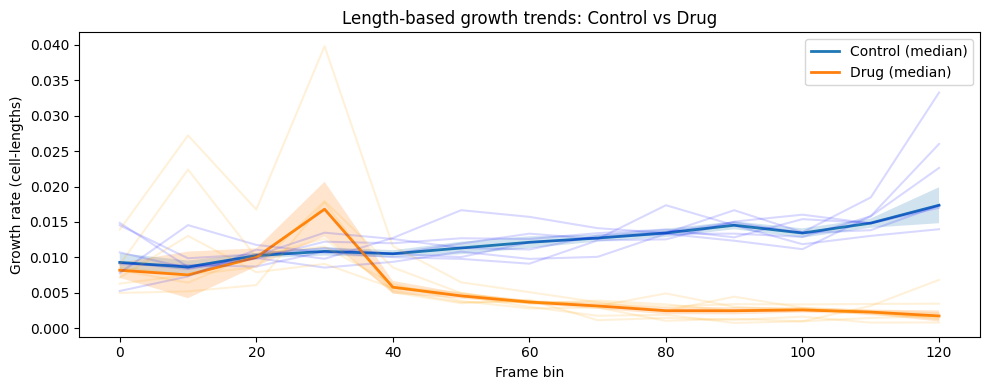

In [57]:
import pandas as pd

control_curves = []
drug_curves = []

for ctrl, drug in pairs:
    a_ctrl = results[ctrl]["agg_length"][["median"]].rename(columns={"median": ctrl})
    a_drug = results[drug]["agg_length"][["median"]].rename(columns={"median": drug})

    control_curves.append(a_ctrl)
    drug_curves.append(a_drug)

ctrl_df = pd.concat(control_curves, axis=1)
drug_df = pd.concat(drug_curves, axis=1)

ctrl_median = ctrl_df.median(axis=1)
drug_median = drug_df.median(axis=1)

ctrl_sem = ctrl_df.std(axis=1) / np.sqrt(ctrl_df.count(axis=1))
drug_sem = drug_df.std(axis=1) / np.sqrt(drug_df.count(axis=1))

plt.figure(figsize=(10,4))

plt.plot(ctrl_median.index, ctrl_median, linewidth=2, label="Control (median)")
plt.fill_between(
    ctrl_median.index,
    ctrl_median - ctrl_sem,
    ctrl_median + ctrl_sem,
    alpha=0.2
)

plt.plot(drug_median.index, drug_median, linewidth=2, label="Drug (median)")
plt.fill_between(
    drug_median.index,
    drug_median - drug_sem,
    drug_median + drug_sem,
    alpha=0.2
)

for col in ctrl_df:
    plt.plot(ctrl_df.index, ctrl_df[col], alpha=0.15, color="blue")

for col in drug_df:
    plt.plot(drug_df.index, drug_df[col], alpha=0.15, color="orange")


plt.xlabel("Frame bin")
plt.ylabel("Growth rate (cell-lengths)")
plt.title("Length-based growth trends: Control vs Drug")
plt.legend()
plt.tight_layout()
plt.show()


## Can we filter away failed trackings?

Filtering strategies to remove failed or unstable cell tracks were considered. However, excluding cells based on track length or continuity would lead to inconsistent cell populations across time, biasing population-level growth estimates. Because cell inclusion would vary between frames, such filtering could introduce artificial changes in aggregated growth rates that are unrelated to true biological effects. For this reason, explicit filtering of failed tracks was not applied.

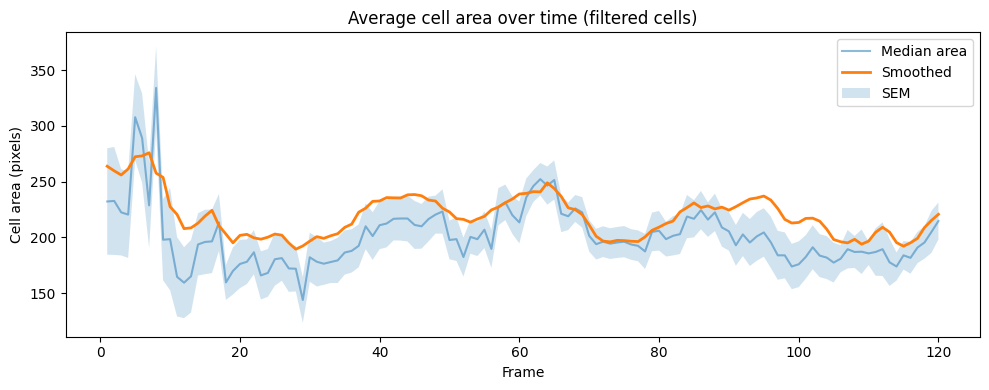

In [61]:
cell_counts = df_raw.groupby("cell_id")["frame"].count()

# Keep only cells with at least N frames
N = 50
valid_cells = cell_counts[cell_counts >= N].index
df_filtered = df_raw[df_raw["cell_id"].isin(valid_cells)]

min_area = 20   # pixels
max_area = 500  # pixels
df_filtered = df_filtered[(df_filtered["area"] >= min_area) &
                          (df_filtered["area"] <= max_area)]

plt.figure(figsize=(10,4))
plt.plot(avr_area.index, avr_area["median"], alpha=0.5, label="Median area")
plt.plot(avr_area.index, avr_area["smooth"], linewidth=2, label="Smoothed")
plt.fill_between(
    avr_area.index,
    avr_area["median"] - avr_area["sem"],
    avr_area["median"] + avr_area["sem"],
    alpha=0.2,
    label="SEM"
)
plt.xlabel("Frame")
plt.ylabel("Cell area (pixels)")
plt.title("Average cell area over time (filtered cells)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from pathlib import Path

# Parameters for filtering
min_frames = 50
min_area = 20
max_area = 500
step = 10  # for binned growth rates

for ctrl, drug in pairs:
    for label, nc_file in [("Control", ctrl), ("Drug", drug)]:
        df_raw, _, _, _ = create_df(Path(f"/content/{nc_file}.nc"), step=step)

        # Filtering
        cell_counts = df_raw.groupby("cell_id")["frame"].count()
        valid_cells = cell_counts[cell_counts >= min_frames].index
        df_filtered = df_raw[df_raw["cell_id"].isin(valid_cells)]
        df_filtered = df_filtered[(df_filtered["area"] >= min_area) &
                                  (df_filtered["area"] <= max_area)]

        # Computing aggregates
        agg_area, agg_length = aggregate_gr(df_filtered, step=step)
        avr_area = average_area(df_filtered)

        if label == "Control":
            agg_ctrl_f = agg_area
            agg_length_ctrl_f = agg_length
            avr_area_ctrl_f = avr_area
        else:
            agg_drug_f = agg_area
            agg_length_drug_f = agg_length
            avr_area_drug_f = avr_area

    visualize_comparison(
        agg_ctrl_f,
        agg_drug_f,
        label1="Control",
        label2="Drug",
        y_label="Growth rate (area)",
        title=f"Area Growth Comparison {ctrl[-3:]}"
    )

    visualize_comparison(
        agg_length_ctrl_f,
        agg_length_drug_f,
        label1="Control",
        label2="Drug",
        y_label="Growth rate (length)",
        title=f"Length Growth Comparison {ctrl[-3:]}"
    )

    visualize_comparison(
        avr_area_ctrl_f,
        avr_area_drug_f,
        label1="Control",
        label2="Drug",
        y_label="Average area",
        title=f"Average Area Comparison {ctrl[-3:]}"
    )

# Plotting Training Metrics for the Model Used in This Study

The arrays containing the training and validation metrics were extracted from the textual training logs produced by DeLTA 2.0, as the framework does not provide built-in functionality for visualizing training curves.


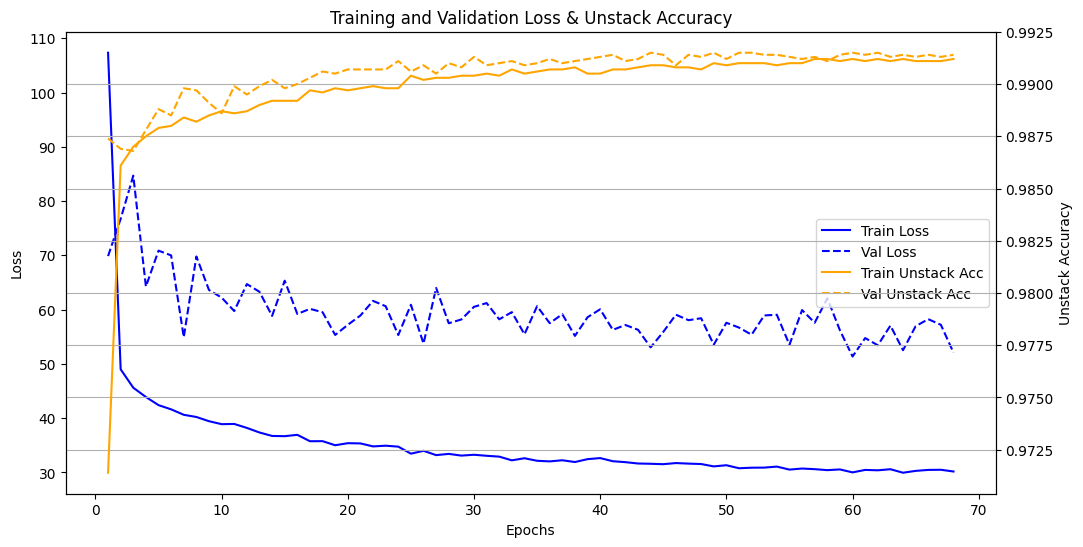

In [73]:
train_loss = [
    107.3530, 48.9965, 45.6094, 43.8992, 42.4017, 41.6219, 40.6187, 40.2158,
    39.4388, 38.8909, 38.9322, 38.2027, 37.3561, 36.7215, 36.6787, 36.9268,
    35.7466, 35.7611, 35.0067, 35.3863, 35.3445, 34.7944, 34.9231, 34.7496,
    33.4531, 33.9855, 33.1867, 33.4149, 33.0990, 33.2529, 33.0637, 32.9089,
    32.2282, 32.6126, 32.1437, 32.0323, 32.2370, 31.9157, 32.4450, 32.6413,
    32.0629, 31.8890, 31.6427, 31.5908, 31.5167, 31.7241, 31.6205, 31.5456,
    31.1090, 31.3253, 30.7691, 30.8694, 30.8835, 31.0714, 30.5195, 30.7141,
    30.5993, 30.4181, 30.5497, 30.0051, 30.4616, 30.3895, 30.5880, 29.9431,
    30.2822, 30.4619, 30.4865, 30.1694
]

val_loss = [
    69.8695, 76.7446, 84.6914, 64.2637, 70.8749, 69.9977, 54.9144, 69.8010,
    63.6177, 62.2193, 59.7435, 64.7102, 63.2912, 58.8446, 65.3394, 59.2014,
    60.1475, 59.5287, 55.3373, 57.1998, 58.9188, 61.6135, 60.6302, 55.3242,
    60.9030, 53.7365, 64.0023, 57.4894, 58.1922, 60.5177, 61.2106, 58.2165,
    59.5445, 55.4544, 60.6306, 57.5108, 59.1599, 55.1615, 58.6053, 60.0638,
    56.2771, 57.1706, 56.2877, 53.0477, 55.8964, 59.0703, 58.0559, 58.4157,
    53.5396, 57.5846, 56.6953, 55.3785, 58.9284, 59.0579, 53.5301, 59.9221,
    57.5846, 62.0960, 56.1870, 51.3614, 54.7630, 53.4304, 57.0569, 52.5239,
    56.9554, 58.2446, 57.1999, 52.0781
]

train_unstack_acc = [
    0.9714, 0.9861, 0.9870, 0.9875, 0.9879, 0.9880, 0.9884, 0.9882,
    0.9885, 0.9887, 0.9886, 0.9887, 0.9890, 0.9892, 0.9892, 0.9892,
    0.9897, 0.9896, 0.9898, 0.9897, 0.9898, 0.9899, 0.9898, 0.9898,
    0.9904, 0.9902, 0.9903, 0.9903, 0.9904, 0.9904, 0.9905, 0.9904,
    0.9907, 0.9905, 0.9906, 0.9907, 0.9907, 0.9908, 0.9905, 0.9905,
    0.9907, 0.9907, 0.9908, 0.9909, 0.9909, 0.9908, 0.9908, 0.9907,
    0.9910, 0.9909, 0.9910, 0.9910, 0.9910, 0.9909, 0.9910, 0.9910,
    0.9912, 0.9912, 0.9911, 0.9912, 0.9911, 0.9912, 0.9911, 0.9912,
    0.9911, 0.9911, 0.9911, 0.9912
]

val_unstack_acc = [
    0.9874, 0.9869, 0.9868, 0.9878, 0.9888, 0.9885, 0.9898, 0.9897,
    0.9891, 0.9886, 0.9899, 0.9895, 0.9899, 0.9902, 0.9898, 0.9900,
    0.9903, 0.9906, 0.9905, 0.9907, 0.9907, 0.9907, 0.9907, 0.9911,
    0.9906, 0.9909, 0.9905, 0.9910, 0.9908, 0.9913, 0.9909, 0.9910,
    0.9911, 0.9909, 0.9910, 0.9912, 0.9910, 0.9911, 0.9912, 0.9913,
    0.9914, 0.9911, 0.9912, 0.9915, 0.9914, 0.9909, 0.9914, 0.9913,
    0.9915, 0.9912, 0.9915, 0.9915, 0.9914, 0.9914, 0.9913, 0.9912,
    0.9913, 0.9911, 0.9914, 0.9915, 0.9914, 0.9915, 0.9913, 0.9914,
    0.9913, 0.9914, 0.9913, 0.9914
]

epochs = range(1, len(train_loss)+1)
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(epochs, train_loss, 'b-', label='Train Loss')
ax1.plot(epochs, val_loss, 'b--', label='Val Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='black')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()
ax2.plot(epochs, train_unstack_acc, color='orange', linestyle='-', label='Train Unstack Acc')
ax2.plot(epochs, val_unstack_acc, color='orange', linestyle='--', label='Val Unstack Acc')
ax2.set_ylabel('Unstack Accuracy', color='black')
ax2.tick_params(axis='y', labelcolor='black')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center right')

plt.title('Training and Validation Loss & Unstack Accuracy')
plt.grid(True)
plt.show()